# Routes annotation with clustering

Source: https://towardsdatascience.com/image-color-segmentation-by-k-means-clustering-algorithm-5792e563f26e

In [2]:
import json
import os
import random
from typing import List
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
%matplotlib inline

import detectron2.data.transforms as T
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode

Extract images from dataset

In [3]:
def create_dataset_dicts(
    img_dir: str, annotation_filename: str = "annotation-bh.json"
) -> List[dict]:
    annotation_json = os.path.join(img_dir, annotation_filename)
    with open(annotation_json, "r") as f:
        img_annotations = json.load(f)["_via_img_metadata"]
    dataset = []
    for id, image in enumerate(img_annotations.values()):
        if not image["regions"]:
            # Skip images that have no region annotation, i.e. not annotated images
            continue
        record = {}
        image_filename = os.path.join(img_dir, image["filename"])
        height, width = cv2.imread(image_filename).shape[:2]

        # Create dataset dict according to detectron2 dataset specification
        # https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#standard-dataset-dicts

        record["file_name"] = image_filename
        record["height"] = height
        record["width"] = width
        record["image_id"] = id

        annotation_objects = []
        for annotation in image["regions"]:
            anno = annotation["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            # Merge point lists and flatten to [x_1, y_1, ..., x_n y_n] format
            polygons = [(x, y) for (x, y) in zip(px, py)]
            polygons = np.ravel(polygons).tolist()
            annotation_obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [polygons],
                "category_id": 0,  # We only have one category
            }
            annotation_objects.append(annotation_obj)
        record["annotations"] = annotation_objects
        dataset.append(record)
    return dataset

In [4]:
for dataset_type in ["test"]:
    DatasetCatalog.register(
        f"hold_{dataset_type}",
        lambda d=dataset_type: create_dataset_dicts(f"cv-bh-data/{d}"),
    )
    MetadataCatalog.get(f"hold_{dataset_type}").thing_classes = ["hold"]
hold_metadata_test = MetadataCatalog.get("hold_test")

In [5]:
dataset_dicts = create_dataset_dicts("cv-bh-data/test")
d_dict = dataset_dicts[0]
image = cv2.imread(d_dict["file_name"])
v = Visualizer(
    image[:, :, ::-1],
    metadata=hold_metadata_test,
    scale=0.5,
    # instance_mode=ColorMode.IMAGE_BW
)

## Extract objects

Convert image to gray

In [6]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
points = np.array([[0,0],[d_dict["width"]-1,0],[d_dict["width"]-1,d_dict["height"]-1],[0,d_dict["height"]-1]])
#print(points)

Create a binary image

(-0.5, 5599.5, 3727.5, -0.5)

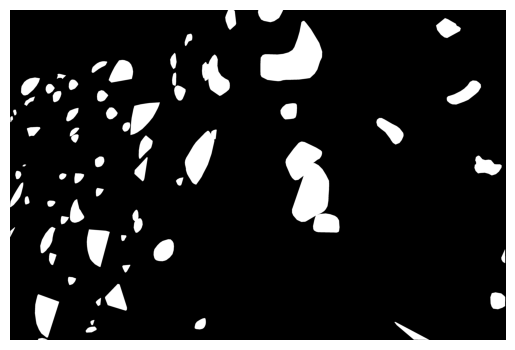

In [7]:
cv2.fillPoly(gray,np.int32([points]),(0,0,0))
for poly in d_dict["annotations"]:
    p=np.array(poly["segmentation"])
    points = np.reshape(p,[int(p.shape[1]/2),2])
    cv2.fillPoly(gray,np.int32([points]),(255,255,255))
#_ , mask = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
mask = gray
plt.imshow(mask, cmap = "gray")
plt.axis('off')

Find Contours and extract Mean Colors

In [8]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

df_mean_color = pd.DataFrame()
for idx, contour in enumerate(contours):
    # get mean color of contour:
    masked = np.zeros_like(image[:, :, 0])  # This mask is used to get the mean color of the specific bead (contour), for kmeans
    cv2.drawContours(masked, [contour], 0, 255, -1)

    B_mean, G_mean, R_mean, _ = cv2.mean(image, mask=masked)
    df = pd.DataFrame({'B_mean': B_mean, 'G_mean': G_mean, 'R_mean': R_mean}, index=[idx])
    df_mean_color = pd.concat([df_mean_color, df])

df_mean_color2 = df_mean_color
#df_mean_color.head()

## Clustering

In [9]:
km = KMeans( n_clusters=5)
km2 = KMedoids( n_clusters=5)
df_mean_color['label'] = km.fit_predict(df_mean_color)
df_mean_color2['label'] = km2.fit_predict(df_mean_color2)

/Users/kirylkisin/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
def draw_segmented_objects(image, contours, label_cnt_idx, holds_count):
    mask = np.zeros_like(image[:, :, 0])
    cv2.drawContours(mask, [contours[i] for i in label_cnt_idx], -1, (255), -1)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    masked_image = cv2.putText(masked_image, f'{holds_count} holdss', (200, 1200), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale = 3, color = (255, 255, 255), thickness = 10, lineType = cv2.LINE_AA)
    return masked_image

(-0.5, 33599.5, 3727.5, -0.5)

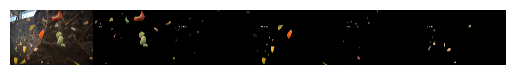

In [11]:
img = image.copy()
for label, df_grouped in df_mean_color.groupby('label'):
    holds_amount = len(df_grouped)
    masked_image = draw_segmented_objects(image, contours, df_grouped.index, holds_amount)
    img = cv2.hconcat([img, masked_image])

cv2.imwrite('color_segmentation.png', img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
plt.axis('off')

(-0.5, 33599.5, 3727.5, -0.5)

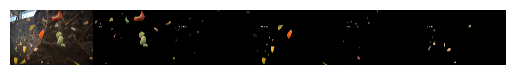

In [12]:
img2 = image.copy()
for label, df_grouped in df_mean_color2.groupby('label'):
    holds_amount = len(df_grouped)
    masked_image = draw_segmented_objects(image, contours, df_grouped.index, holds_amount)
    img2 = cv2.hconcat([img2, masked_image])

cv2.imwrite('color_segmentation2.png', img2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) )
plt.axis('off')